Statistics for Artificial Intelligence and Data Science

Aims and Outline

The overall aim of this notebook is to carry out an exploratory analysis of data with both continuous and categorical and Use regression modelling to look at the effect of predictor variables on a target 
variable. This notebook explain how well the proposed variables can predict the bridge condition and Which of the proposed variables has more influence on the current condition.

 1. Part 1: Data preparation
     1. Creating derived variables
     1. Removing outliers
     1. Merging very small categories.
     1. Deriving current condition
     1. Distribution of variables.
       
 2. Part 2: Exploratory Analysis
     1. Relationship between continuous variable
     1. Relationship between categorical variable
     1. Relationship between continuous and categorical variable
      
 3. Part 3: Regression Modelling
     1. R2 (coefficient of determination) and comment
     1. Influence of different predictors
     1. Distribution of errors and comment
     1. Final conclusion

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
%matplotlib inline


##  Introducing the Data Set

This notebook looks at some data from the US National Bridge Inspection maintained by the Federal Highways Agency (FHWA), part of the US Department of Transportation. The aim of the Bridge Inspection programme is to check on the state of bridges so that necessary repairs can be carried out. If this is not done, a bridge can fail. The dataset has information about the bridges and the condition given in the most recent inspection.

###  Loading data from a CSV file
We can load the data from the CSV file. A 'type map' is used to set the types of each variables. Without this, Pandas guesses at the types, representing non-numeric fields as string. Instead, we represent them as Categorical Variables: using type `category` gives the default behaviour (use each unique value as a category and categories are not ordered). However, for the ordinal variables (categorical variables with an order) we must declare a suitable type explicitly.

In [ ]:
# The code below declares a catageorical type with categories in a specified order
# This can be used for an ordinal variable
rating_type = pd.CategoricalDtype(
    categories=['Failed', 'Failing', 'Critical', 'Serious', 'Poor', 'Fair', 
                'Satisfactory', 'Good', 'Very Good', 'Excellent', 'NA'], 
    ordered=True)

# This one is also for an ordinal variable, but with a slightly different set of values
scour_type = pd.CategoricalDtype(
    categories=['Unknown', 'Critical','Unstable', 'Stable', 'Protected', 'Dry', 'No waterway'], 
    ordered=True)

types_dict = {'Structure_id': str, 'District':'category', 'Toll':'category', 
              'Maintainer':'category', 'Urban':'category', 'Status':'category', 
              'Historic':'category', 'Service_under':'category', 'Material':'category', 
              'Design':'category', 
              'Deck_rating':rating_type, 'Superstr_rating':rating_type, 'Substr_rating':rating_type, 
              'Scour_rating':scour_type}

df = pd.read_csv('tx19_bridges_sample.csv', dtype = types_dict, index_col = 'Structure_id')
df

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,2,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,1,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,1,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150
000021525-00012,District2,199,Free,Agency,Rural,Local,1950,1,0,80,...,14,45.4,3.7,Good,Good,Poor,10.0,0.0,Dry,120
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,...,1,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,District9,0,Free,Military,Urban,Local,1994,3,0,300,...,3,45.4,19.0,Good,Good,Good,64.3,40.0,No waterway,600
DAPFORHOO000013,District9,0,Free,Military,Urban,Local,2000,2,0,300,...,1,12.3,10.8,Good,Good,Good,35.1,40.0,No waterway,600
DAPFORHOO000015,District9,0,Free,Military,Urban,Minor,1996,2,7,1200,...,4,73.2,9.8,Good,Good,Good,24.5,25.0,No waterway,1500


## Part 1: Data preparation

This section focus on preparing data by using some variables, remove outliers, merging very small categories and will see the distribution.


### Part 1.1: Creating derived variables

Will focus on below mentioned continuous and categorical variables.

- Age (derived from variable Year)
- Average use (variable AverageDaily)
- Percent trucks (variable Trucks_percent)
- Material (variable Material)
- Design (variable Design)

In [ ]:
# Applying Filtering for creating dataframe based on these variables.
bridges1 = df[['Year','AverageDaily','Trucks_percent','Material','Design','Deck_rating', 'Superstr_rating','Substr_rating']]
bridges1

,Year,AverageDaily,Trucks_percent,Material,Design,Deck_rating,Superstr_rating,Substr_rating
Structure_id,,,,,,,,
000021521-00101,2005,1,0.0,Concrete,Slab,Good,Very Good,Very Good
000021521-00181,2005,1,0.0,Concrete,Slab,Good,Good,Very Good
000021521-TMP20,2012,100,0.0,Concrete,Beam,Very Good,Very Good,Very Good
000021525-00012,1950,80,0.0,Timber,Beam,Good,Good,Poor
000021580-00092,2004,150,4.0,Concrete,Beam,Good,Very Good,Very Good
...,...,...,...,...,...,...,...,...
DAPFORHOO000012,1994,300,40.0,Concrete,Beam,Good,Good,Good
DAPFORHOO000013,2000,300,40.0,Concrete,Beam,Good,Good,Good
DAPFORHOO000015,1996,1200,25.0,Concrete,Beam,Good,Good,Good


In [ ]:
# Deriving Age variable from Year variable
bridges2 = bridges1.assign(Age=(2021-bridges1.Year))
bridges2

,Year,AverageDaily,Trucks_percent,Material,Design,Deck_rating,Superstr_rating,Substr_rating,Age
Structure_id,,,,,,,,,
000021521-00101,2005,1,0.0,Concrete,Slab,Good,Very Good,Very Good,16
000021521-00181,2005,1,0.0,Concrete,Slab,Good,Good,Very Good,16
000021521-TMP20,2012,100,0.0,Concrete,Beam,Very Good,Very Good,Very Good,9
000021525-00012,1950,80,0.0,Timber,Beam,Good,Good,Poor,71
000021580-00092,2004,150,4.0,Concrete,Beam,Good,Very Good,Very Good,17
...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,1994,300,40.0,Concrete,Beam,Good,Good,Good,27
DAPFORHOO000013,2000,300,40.0,Concrete,Beam,Good,Good,Good,21
DAPFORHOO000015,1996,1200,25.0,Concrete,Beam,Good,Good,Good,25


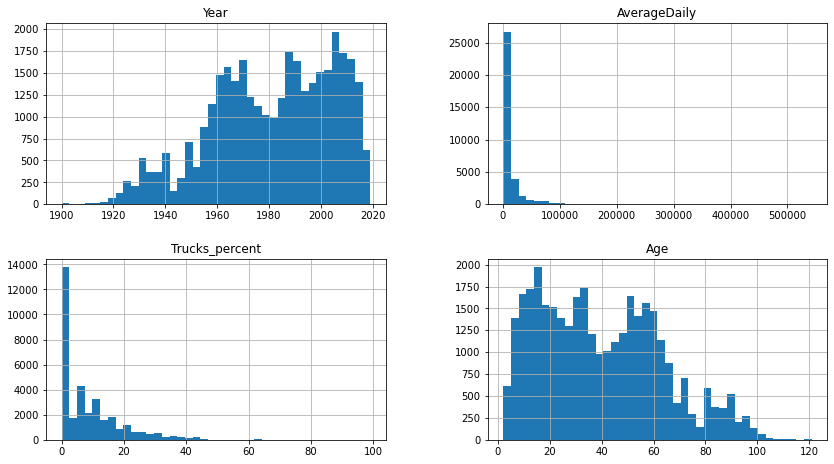

In [ ]:
# # The hist method ignores categorical variables, so we can just apply to to everything
ax = bridges2.hist(bins=40, figsize=(14,25), layout=(6,2))

### Part 1.2: Removing outliers

Any data point outside this range is considered as outlier and should be removed for further analysis.

lower limit as Q1–1.5*IQR and upper limit as Q3+1.5*IQR.

In [ ]:
#Removing outliers that are outside the range
bridges3 = bridges2.loc[(bridges2.Age < 100) & (bridges2.AverageDaily < 200000)]
bridges3

,Year,AverageDaily,Trucks_percent,Material,Design,Deck_rating,Superstr_rating,Substr_rating,Age
Structure_id,,,,,,,,,
000021521-00101,2005,1,0.0,Concrete,Slab,Good,Very Good,Very Good,16
000021521-00181,2005,1,0.0,Concrete,Slab,Good,Good,Very Good,16
000021521-TMP20,2012,100,0.0,Concrete,Beam,Very Good,Very Good,Very Good,9
000021525-00012,1950,80,0.0,Timber,Beam,Good,Good,Poor,71
000021580-00092,2004,150,4.0,Concrete,Beam,Good,Very Good,Very Good,17
...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,1994,300,40.0,Concrete,Beam,Good,Good,Good,27
DAPFORHOO000013,2000,300,40.0,Concrete,Beam,Good,Good,Good,21
DAPFORHOO000015,1996,1200,25.0,Concrete,Beam,Good,Good,Good,25


### Part 1.3: Merging very small categories

It is better to reduce number of categories and simplify them. We will do this step by step first in 'Material' and then in 'Design' variable.

In [ ]:
# below code will replace small category 'Masonry' by 'other'
bridges4= bridges3.replace({'Material': {'Masonry': 'Other'}})
bridges4

,Year,AverageDaily,Trucks_percent,Material,Design,Deck_rating,Superstr_rating,Substr_rating,Age
Structure_id,,,,,,,,,
000021521-00101,2005,1,0.0,Concrete,Slab,Good,Very Good,Very Good,16
000021521-00181,2005,1,0.0,Concrete,Slab,Good,Good,Very Good,16
000021521-TMP20,2012,100,0.0,Concrete,Beam,Very Good,Very Good,Very Good,9
000021525-00012,1950,80,0.0,Timber,Beam,Good,Good,Poor,71
000021580-00092,2004,150,4.0,Concrete,Beam,Good,Very Good,Very Good,17
...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,1994,300,40.0,Concrete,Beam,Good,Good,Good,27
DAPFORHOO000013,2000,300,40.0,Concrete,Beam,Good,Good,Good,21
DAPFORHOO000015,1996,1200,25.0,Concrete,Beam,Good,Good,Good,25


In [ ]:
# below code will replace small category 'Movable' and 'suspension' by 'other'
bridges5 =bridges4.replace({'Design': {'Movable': 'Other', 'Suspension':'Other'}})
bridges5

,Year,AverageDaily,Trucks_percent,Material,Design,Deck_rating,Superstr_rating,Substr_rating,Age
Structure_id,,,,,,,,,
000021521-00101,2005,1,0.0,Concrete,Slab,Good,Very Good,Very Good,16
000021521-00181,2005,1,0.0,Concrete,Slab,Good,Good,Very Good,16
000021521-TMP20,2012,100,0.0,Concrete,Beam,Very Good,Very Good,Very Good,9
000021525-00012,1950,80,0.0,Timber,Beam,Good,Good,Poor,71
000021580-00092,2004,150,4.0,Concrete,Beam,Good,Very Good,Very Good,17
...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,1994,300,40.0,Concrete,Beam,Good,Good,Good,27
DAPFORHOO000013,2000,300,40.0,Concrete,Beam,Good,Good,Good,21
DAPFORHOO000015,1996,1200,25.0,Concrete,Beam,Good,Good,Good,25


### Part 1.4: Deriving current condition

Current condition should be derived from the combination of the three main condition variables (ignore 'scour'), by treating each as an integer score (0 for failed) and adding the three scores. 

In [ ]:
# Below created function add a new column and replace Deck_rating with integers.
def grade(row):
    if (row.Deck_rating == 'Failed') : return 0
    if (row.Deck_rating == 'Failing') : return 1
    if (row.Deck_rating == 'Critical') : return 2
    if (row.Deck_rating == 'Serious') : return 3
    if (row.Deck_rating == 'Poor') : return 4
    if (row.Deck_rating == 'Fair') : return 5
    if (row.Deck_rating == 'Satisfactory') : return 6
    if (row.Deck_rating == 'Good') : return 7
    if (row.Deck_rating == 'Very Good') : return 8
    if (row.Deck_rating == 'Excellent') : return 9
     
bridges6=bridges5.assign(Deck_rating_value= bridges5.apply(grade, axis=1))
bridges6

,Year,AverageDaily,Trucks_percent,Material,Design,Deck_rating,Superstr_rating,Substr_rating,Age,Deck_rating_value
Structure_id,,,,,,,,,,
000021521-00101,2005,1,0.0,Concrete,Slab,Good,Very Good,Very Good,16,7.0
000021521-00181,2005,1,0.0,Concrete,Slab,Good,Good,Very Good,16,7.0
000021521-TMP20,2012,100,0.0,Concrete,Beam,Very Good,Very Good,Very Good,9,8.0
000021525-00012,1950,80,0.0,Timber,Beam,Good,Good,Poor,71,7.0
000021580-00092,2004,150,4.0,Concrete,Beam,Good,Very Good,Very Good,17,7.0
...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,1994,300,40.0,Concrete,Beam,Good,Good,Good,27,7.0
DAPFORHOO000013,2000,300,40.0,Concrete,Beam,Good,Good,Good,21,7.0
DAPFORHOO000015,1996,1200,25.0,Concrete,Beam,Good,Good,Good,25,7.0


In [ ]:
# Below created function add a new column and replace Superstr_rating with integers.
def grade1(row):
    if (row.Superstr_rating == 'Failed') : return 0
    if (row.Superstr_rating == 'Failing') : return 1
    if (row.Superstr_rating == 'Critical') : return 2
    if (row.Superstr_rating == 'Serious') : return 3
    if (row.Superstr_rating == 'Poor') : return 4
    if (row.Superstr_rating == 'Fair') : return 5
    if (row.Superstr_rating == 'Satisfactory') : return 6
    if (row.Superstr_rating== 'Good') : return 7
    if (row.Superstr_rating == 'Very Good') : return 8
    if (row.Superstr_rating == 'Excellent') : return 9
     
bridges7=bridges6.assign(Superstr_rating_value= bridges6.apply(grade1, axis=1))
bridges7

,Year,AverageDaily,Trucks_percent,Material,Design,Deck_rating,Superstr_rating,Substr_rating,Age,Deck_rating_value,Superstr_rating_value
Structure_id,,,,,,,,,,,
000021521-00101,2005,1,0.0,Concrete,Slab,Good,Very Good,Very Good,16,7.0,8.0
000021521-00181,2005,1,0.0,Concrete,Slab,Good,Good,Very Good,16,7.0,7.0
000021521-TMP20,2012,100,0.0,Concrete,Beam,Very Good,Very Good,Very Good,9,8.0,8.0
000021525-00012,1950,80,0.0,Timber,Beam,Good,Good,Poor,71,7.0,7.0
000021580-00092,2004,150,4.0,Concrete,Beam,Good,Very Good,Very Good,17,7.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,1994,300,40.0,Concrete,Beam,Good,Good,Good,27,7.0,7.0
DAPFORHOO000013,2000,300,40.0,Concrete,Beam,Good,Good,Good,21,7.0,7.0
DAPFORHOO000015,1996,1200,25.0,Concrete,Beam,Good,Good,Good,25,7.0,7.0


In [ ]:
# Below created function add a new column and replace Substr_rating with integers.
def grade2(row):
    if (row.Substr_rating == 'Failed') : return 0
    if (row.Substr_rating == 'Failing') : return 1
    if (row.Substr_rating == 'Critical') : return 2
    if (row.Substr_rating == 'Serious') : return 3
    if (row.Substr_rating == 'Poor') : return 4
    if (row.Substr_rating == 'Fair') : return 5
    if (row.Substr_rating == 'Satisfactory') : return 6
    if (row.Substr_rating== 'Good') : return 7
    if (row.Substr_rating == 'Very Good') : return 8
    if (row.Substr_rating == 'Excellent') : return 9
     
bridges8=bridges7.assign(Substr_rating_value= bridges7.apply(grade2, axis=1))
bridges8

,Year,AverageDaily,Trucks_percent,Material,Design,Deck_rating,Superstr_rating,Substr_rating,Age,Deck_rating_value,Superstr_rating_value,Substr_rating_value
Structure_id,,,,,,,,,,,,
000021521-00101,2005,1,0.0,Concrete,Slab,Good,Very Good,Very Good,16,7.0,8.0,8
000021521-00181,2005,1,0.0,Concrete,Slab,Good,Good,Very Good,16,7.0,7.0,8
000021521-TMP20,2012,100,0.0,Concrete,Beam,Very Good,Very Good,Very Good,9,8.0,8.0,8
000021525-00012,1950,80,0.0,Timber,Beam,Good,Good,Poor,71,7.0,7.0,4
000021580-00092,2004,150,4.0,Concrete,Beam,Good,Very Good,Very Good,17,7.0,8.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,1994,300,40.0,Concrete,Beam,Good,Good,Good,27,7.0,7.0,7
DAPFORHOO000013,2000,300,40.0,Concrete,Beam,Good,Good,Good,21,7.0,7.0,7
DAPFORHOO000015,1996,1200,25.0,Concrete,Beam,Good,Good,Good,25,7.0,7.0,7


### Deriving current condition by adding the three scores.

In [ ]:
# Below code add a column of current condtion by adding three scores.
bridges8['Condition']=bridges8['Deck_rating_value']+bridges8['Superstr_rating_value']+bridges8['Substr_rating_value']
bridges8

,Year,AverageDaily,Trucks_percent,Material,Design,Deck_rating,Superstr_rating,Substr_rating,Age,Deck_rating_value,Superstr_rating_value,Substr_rating_value,Condition
Structure_id,,,,,,,,,,,,,
000021521-00101,2005,1,0.0,Concrete,Slab,Good,Very Good,Very Good,16,7.0,8.0,8,23.0
000021521-00181,2005,1,0.0,Concrete,Slab,Good,Good,Very Good,16,7.0,7.0,8,22.0
000021521-TMP20,2012,100,0.0,Concrete,Beam,Very Good,Very Good,Very Good,9,8.0,8.0,8,24.0
000021525-00012,1950,80,0.0,Timber,Beam,Good,Good,Poor,71,7.0,7.0,4,18.0
000021580-00092,2004,150,4.0,Concrete,Beam,Good,Very Good,Very Good,17,7.0,8.0,8,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,1994,300,40.0,Concrete,Beam,Good,Good,Good,27,7.0,7.0,7,21.0
DAPFORHOO000013,2000,300,40.0,Concrete,Beam,Good,Good,Good,21,7.0,7.0,7,21.0
DAPFORHOO000015,1996,1200,25.0,Concrete,Beam,Good,Good,Good,25,7.0,7.0,7,21.0


In [ ]:
# Dropping the variables that are not required.
# Dimensionality reduction from 13 columns to 9 columns
bridges9=bridges8.drop(['Year', 'Deck_rating_value', 'Superstr_rating_value', 'Substr_rating_value'], axis=1)
bridges9

,AverageDaily,Trucks_percent,Material,Design,Deck_rating,Superstr_rating,Substr_rating,Age,Condition
Structure_id,,,,,,,,,
000021521-00101,1,0.0,Concrete,Slab,Good,Very Good,Very Good,16,23.0
000021521-00181,1,0.0,Concrete,Slab,Good,Good,Very Good,16,22.0
000021521-TMP20,100,0.0,Concrete,Beam,Very Good,Very Good,Very Good,9,24.0
000021525-00012,80,0.0,Timber,Beam,Good,Good,Poor,71,18.0
000021580-00092,150,4.0,Concrete,Beam,Good,Very Good,Very Good,17,23.0
...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,300,40.0,Concrete,Beam,Good,Good,Good,27,21.0
DAPFORHOO000013,300,40.0,Concrete,Beam,Good,Good,Good,21,21.0
DAPFORHOO000015,1200,25.0,Concrete,Beam,Good,Good,Good,25,21.0


In [ ]:
# Dropping Nan Values
bridges = bridges9.dropna()
bridges

,AverageDaily,Trucks_percent,Material,Design,Deck_rating,Superstr_rating,Substr_rating,Age,Condition
Structure_id,,,,,,,,,
000021521-00101,1,0.0,Concrete,Slab,Good,Very Good,Very Good,16,23.0
000021521-00181,1,0.0,Concrete,Slab,Good,Good,Very Good,16,22.0
000021521-TMP20,100,0.0,Concrete,Beam,Very Good,Very Good,Very Good,9,24.0
000021525-00012,80,0.0,Timber,Beam,Good,Good,Poor,71,18.0
000021580-00092,150,4.0,Concrete,Beam,Good,Very Good,Very Good,17,23.0
...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,300,40.0,Concrete,Beam,Good,Good,Good,27,21.0
DAPFORHOO000013,300,40.0,Concrete,Beam,Good,Good,Good,21,21.0
DAPFORHOO000015,1200,25.0,Concrete,Beam,Good,Good,Good,25,21.0


### Part 1.5: Distribution of variables

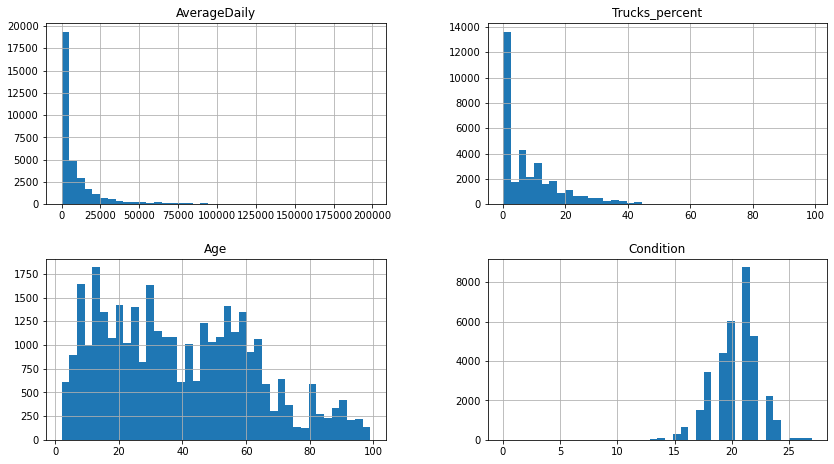

In [ ]:
# The hist method ignores categorical variables, so we can just apply to to everything
# below code helps in Creating histograms and seeing distribution
ax1 = bridges.hist(bins=40, figsize=(14,25), layout=(6,2))

Current condition variable seems to be normally distributed. AverageDaily and Truck_percent found right skewed. Age histogram seems slightly right skewed.

## Part 2:  Exploratory Analysis

This section see the relationship between the five predictor variables and the target variable and comment on the relationship between the predictors. We will do preliminary conclusions at the end of this part of the analysis on the answers to the questions asked by the Texas Department of Transportation. 

### Part 2.1: Correlation of Continuous Variables

Current condition should be derived from the combination of the three main condition variables (ignore 'scour'), by treating each as an integer score (0 for failed) and adding the three scores. 

### Correlation Matrix
The correlation coefficient between the continuous variables in the data frame can be calculated using `.corr()`. Conventionally, the categorical variables are just ignored.

In [ ]:
# below code shows the correlation
bridges.corr()

,AverageDaily,Trucks_percent,Age,Condition
AverageDaily,1.000000,0.030927,-0.045701,0.028466
Trucks_percent,0.030927,1.000000,0.227711,-0.048543
Age,-0.045701,0.227711,1.000000,-0.590207
Condition,0.028466,-0.048543,-0.590207,1.000000


**Heat Map** The correlation is often shown as heat map.

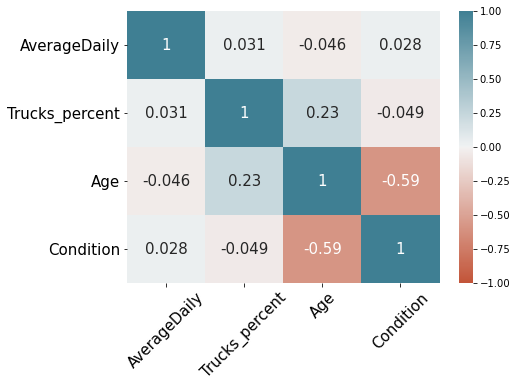

In [ ]:
# below code shows the heat map of continuous variables
fig,ax = plt.subplots(1,1, figsize=(7,5))
sns.heatmap(bridges.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True),
annot=True, ax=ax, annot_kws={"size": 15})
_y = plt.yticks(rotation=0, fontsize=15)
_x = plt.xticks(rotation=45, fontsize=15)

### Interpretation of above heat map

- AverageDaily : 
1. No correlation with Truck_percent & Condition
2. Slightly less correlation with Age

- Trucks_percent : 
1. Slightly negetive correlation with Condition
2. Slightly positive correlation with Age

- Age : 
strong negetive correlation with condition

### Scatter Matrix

Pandas provides a function to plot 'scatter matrix', which shows a scatter plot of all the numeric variables (with distributions on the diagonal axis; kde are available as well). 

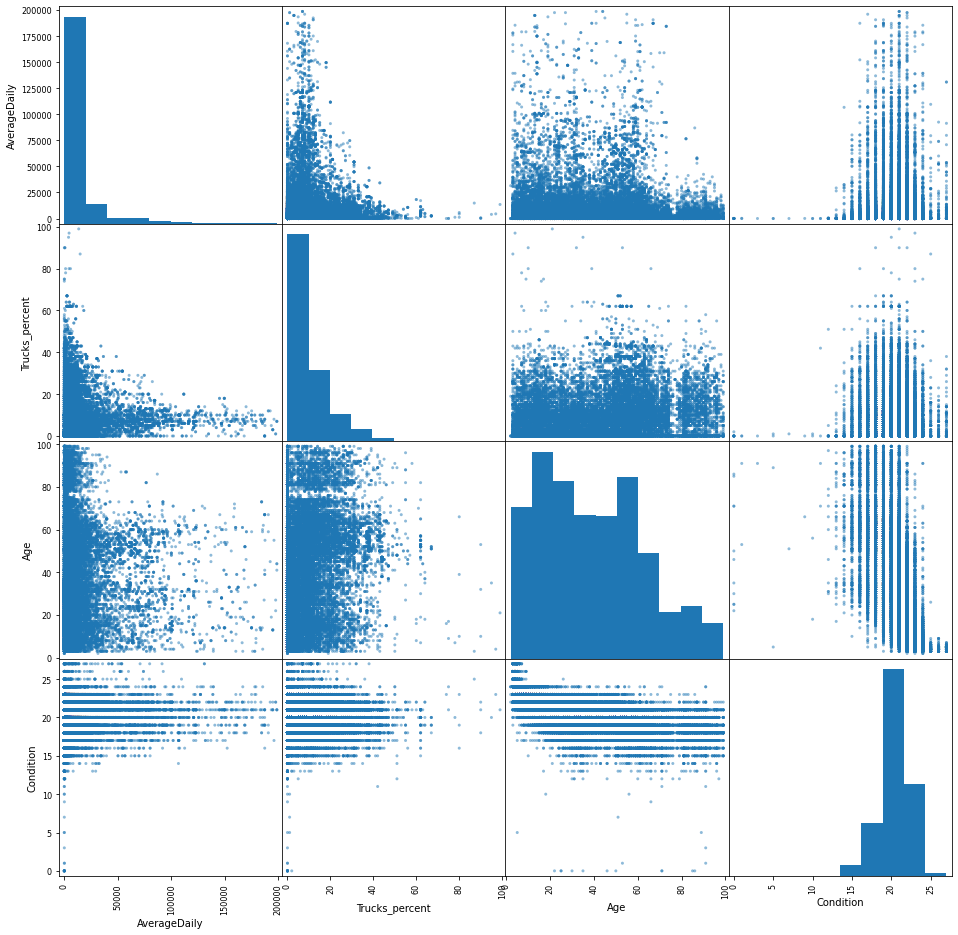

In [ ]:
_a = pd.plotting.scatter_matrix(bridges, figsize=(16,16))
# The variable on the left hand side _a is useful as otherwise the return value (121 axes) is displayed. 
# We assign it to a variable to stop this happening. Starting the name with an underscore is a convention
# for saying 'dummy variable' 

### Interpretation of above Scatter matrix

- AverageDaily : 
1. No correlation with Truck_percent & Condition
2. Slightly less correlation with Age

- Trucks_percent : 
1. Slightly negetive correlation with Condition
2. Slightly positive correlation with Age

- Age : 
strong negetive correlation with condition 

### Scatter Plots using a Sample of Data

<AxesSubplot:xlabel='AverageDaily', ylabel='Condition'>

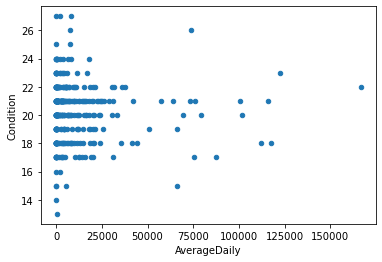

In [ ]:
# below code select 1 % of sample data and plot scatter
# This is use when very dense scatter plots
bridges.sample(frac=0.01).plot(kind='scatter', x='AverageDaily', y='Condition')

<AxesSubplot:xlabel='Trucks_percent', ylabel='Condition'>

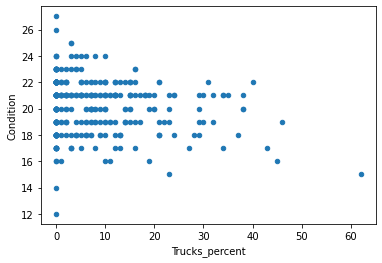

In [ ]:
# below code select 1 % of sample data and plot scatter
# This is use when very dense scatter plots
bridges.sample(frac=0.01).plot(kind='scatter', x='Trucks_percent', y='Condition')

<AxesSubplot:xlabel='Age', ylabel='Condition'>

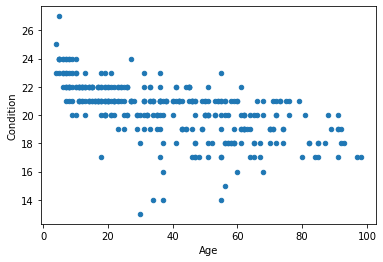

In [ ]:
# below code select 1 % of sample data and plot scatter
# This is use when very dense scatter plots
bridges.sample(frac=0.01).plot(kind='scatter', x='Age', y='Condition')

### Part 2.2: Relationship between categorical Variables

This section looks at the categorical variables. We first use `crosstab` to cross tabulate variables in a table (also called a contingency table). We then consider how to show conditional probability distributions using bar charts before also using a `heatmap` to display conditional probabilities. 

### Cross-tabulating Categorical Variables

We can normalise over all values creates a joint probability distribution. We can add totals to this, which show the marginal probability distribution of the two variables.

In [ ]:
# below code will evaluate the relationship between Material and desing (joint probability)
#   The first parameter is the index
#   The second parameter is the columns
Mat_and_des = pd.crosstab(bridges.Material, [bridges.Design], normalize='all')
Mat_and_des.round(4)*100

Design,Arch,Beam,Frame,Other,Slab,Truss
Material,,,,,,
Concrete,0.20,63.53,0.2,2.71,12.59,0.00
Other,0.05,0.00,0.0,0.12,0.00,0.00
Steel,0.16,17.92,0.0,0.86,0.00,0.29
Timber,0.00,1.36,0.0,0.00,0.00,0.00


### Plotting Probability Distributions

<AxesSubplot:xlabel='Material'>

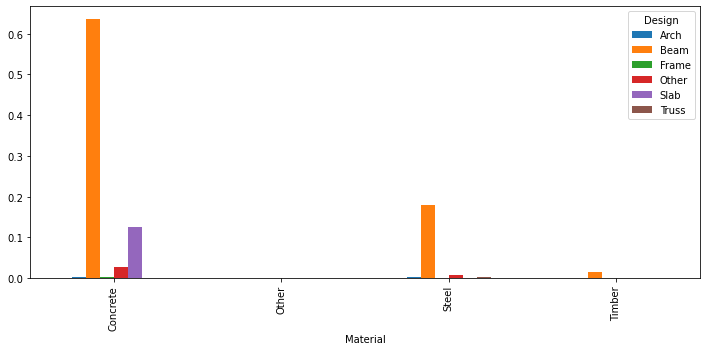

In [ ]:
# Plotting bar chart
Mat_and_des.plot(kind='bar',figsize=(12,5))

Below now we can normalise over the index. This makes all the rows sum to 1, giving probability of the variable on the x-axis, given the variable on the y-axis.

In [ ]:
# below code will evaluate the relationship between Material and desing (condtional probability)
#   The first parameter is the index
#   The second parameter is the columns
Mat_given_des = pd.crosstab(bridges.Design, [bridges.Material], normalize='index')
Mat_given_des.round(4)*100

Material,Concrete,Other,Steel,Timber
Design,,,,
Arch,50.00,11.59,38.41,0.00
Beam,76.71,0.00,21.64,1.65
Frame,100.00,0.00,0.00,0.00
Other,73.35,3.34,23.23,0.08
Slab,100.00,0.00,0.00,0.00
Truss,0.00,0.00,100.00,0.00


### Plotting Probability Distributions

<AxesSubplot:xlabel='Design'>

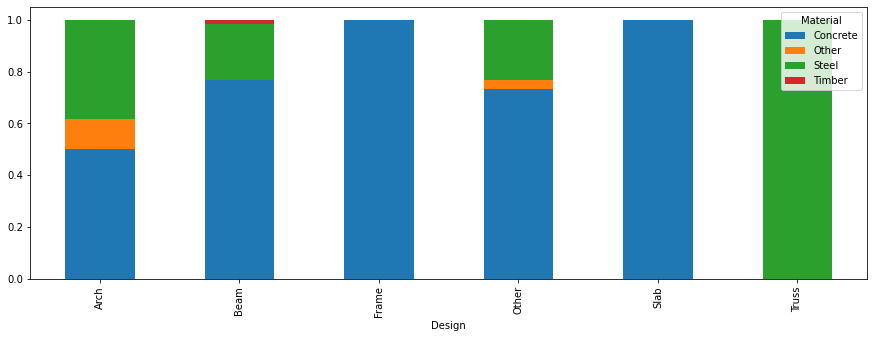

In [ ]:
Mat_given_des.plot(kind='bar',figsize=(15,5),stacked = True)

### Interpretation

- All Truss type designs are made of steel.
- All slab type designs are made of concrete.
- All Frame type designs are made of concrete.
- Arch type designs are made of 3 material 
- Timber material is used very rare only in beam type design.

### Heatmap of (Conditional) Probabilities

Text(0.5, 1.0, 'Material given Design')

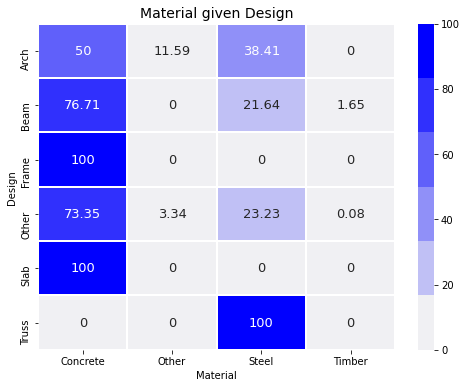

In [ ]:
# below code generating heat map between two categorical variables
fig,ax = plt.subplots(1,1, figsize=(8,6))
sns.heatmap(Mat_given_des.round(4)*100, cmap=sns.light_palette('blue'), linewidths = 2,
            annot=True, ax=ax, annot_kws={"size": 13}, fmt='g')
ax.set_title('Material given Design', fontsize=14)

### Interpretation of above heat map

-Concrete : strong positive correlation with all type of designs except Truss type


- Steel : 
1. strong positive correlation with Truss design
2. No correlation with Slab and Frame design

- Timber & Other: No correlation with any design type

Below to get the other conditional probability, we swap the parameters but still normalise the index. This seems better for plotting.

In [ ]:
# below code will evaluate the relationship between Material and desing (condtional probability)
#   The first parameter is the index
#   The second parameter is the columns
des_given_Mat = pd.crosstab(bridges.Material, [bridges.Design], normalize='index')
des_given_Mat.round(4)*100

Design,Arch,Beam,Frame,Other,Slab,Truss
Material,,,,,,
Concrete,0.26,80.19,0.25,3.42,15.89,0.00
Other,27.59,0.00,0.00,72.41,0.00,0.00
Steel,0.81,93.20,0.00,4.46,0.00,1.53
Timber,0.00,99.78,0.00,0.22,0.00,0.00


### Plotting Probability Distributions

<AxesSubplot:xlabel='Material'>

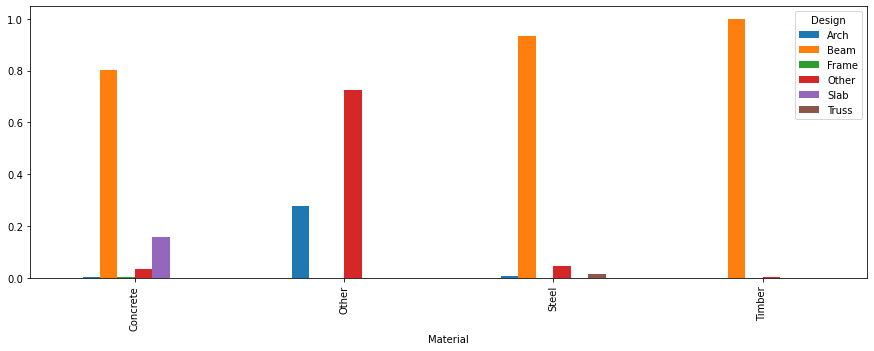

In [ ]:
des_given_Mat.plot(kind='bar',figsize=(15,5),stacked = False)

### Interpretation

- Concrete bridges are having beam, slab and other designs
- other bridges are only having Arch and other designs

Beam design is the most preferable design as used in bridges made of concrete, steel and timber.

### Heatmap of (Conditional) Probabilities

Text(0.5, 1.0, 'design given Material')

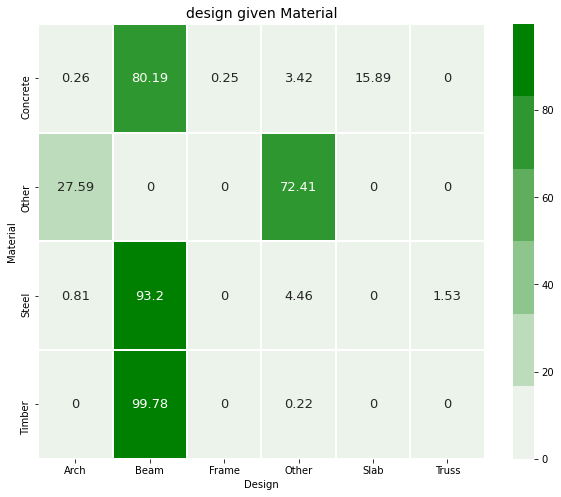

In [ ]:
# below code generating heat map between two categorical variables by reversing them
fig,ax = plt.subplots(1,1, figsize=(10,8))
sns.heatmap(des_given_Mat.round(4)*100, cmap=sns.light_palette('green'), linewidths = 2,
            annot=True, ax=ax, annot_kws={"size": 13}, fmt='g')
ax.set_title('design given Material', fontsize=14)

### Interpretation of above heat map

-Concrete , steel, Timber material bridges : 

Strong positive correlation with beam type design

Truss design has no correlation with any type of material.

### Part 2.3: Relationship between continuous and categorical Variables

We are interested to understand how the continuous variables (such as Condition) are *correlated* (in the general sense) with categorical variables with one (or more) of the categorical variables. This is, we can ask how the distribution of the continuous variable (or its statistics) changes given the value of the category.


### Using Box Plots to Compare the Distribution of one Variable by Another Variable

Recall that a boxplot is really a visualisation of the summary statistics of a distribution. The `boxplot` can select a variable whose distribution is to be summarised (the `column=` argument) and a categorical variable (the `by=` argument) so that a separate summary is shown for each category.

There are some examples below.

Text(0, 0.5, 'Condition')

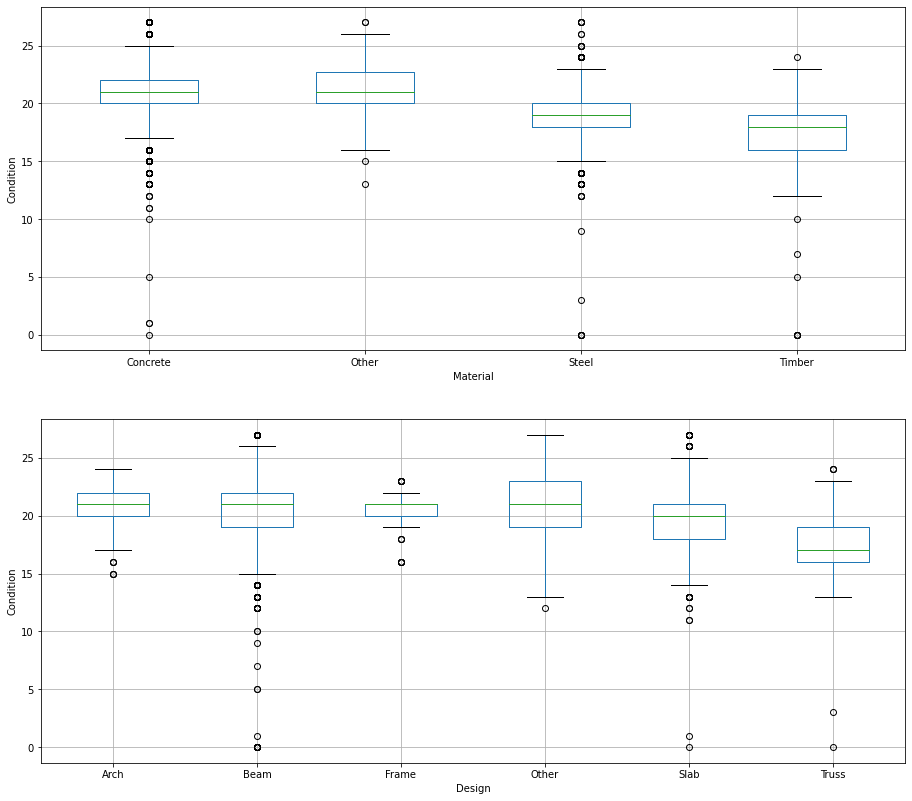

In [ ]:
# below code generating box plots for each category
fig, (a1, a2) = plt.subplots(2,1, figsize=(15,14))

bridges.boxplot(column='Condition', by='Material', ax=a1)
bridges.boxplot(column='Condition', by='Design', ax=a2)

# Make the plots a bit clearer
fig.suptitle('')
[a.set_title('') for a in [a1, a2]]
a1.set_ylabel('Condition')
a2.set_ylabel('Condition')

### Interpretation of above box plot

Material box plot

-Concrete and other material have median of above 20 and more outliers are present in concrete.
-Steel and timber have median below 20
-Steel and timber have Q3 below 20
-Q1 and Q3 in concrete are 20 and 22 respectively
-Q1 and Q3 in other are 20 and 23 respectively

Design box plot

- All design types have a median of 20 and above except Truss design which has median of less than 20
- only concrete has Q1 of 20 but rest all other design type having Q1 of below 20
- Frame type design observed minimum rating.

### Using `groupby` to Partition a Data Frame

The `by=` parameter of the box plot is not generally available. Instead, we use the Pandas `groupby` method. The effect of this is to partition a data frame into a set of data frame, one for each value of a categorical 

In [ ]:
#The following code creates a group by using the 'Material' category
gbyMat = bridges.groupby(by = 'Material')
gbyMat.size()

Material
Concrete    26966
Other          58
Steel        6545
Timber        465
dtype: int64

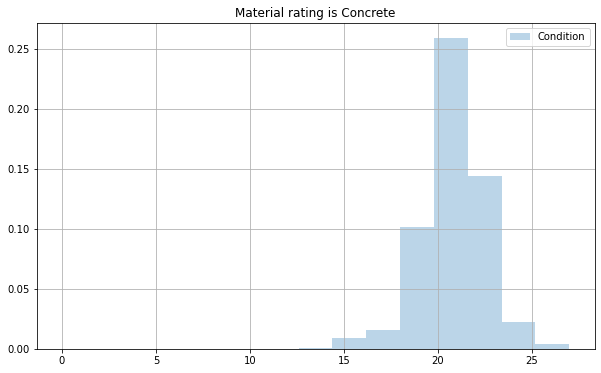

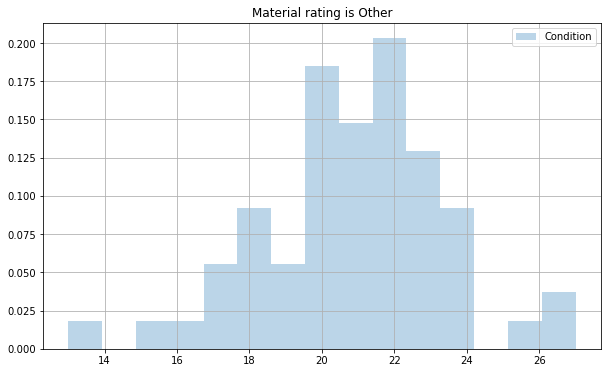

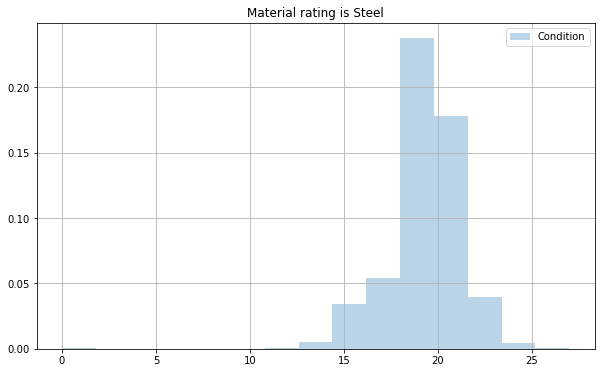

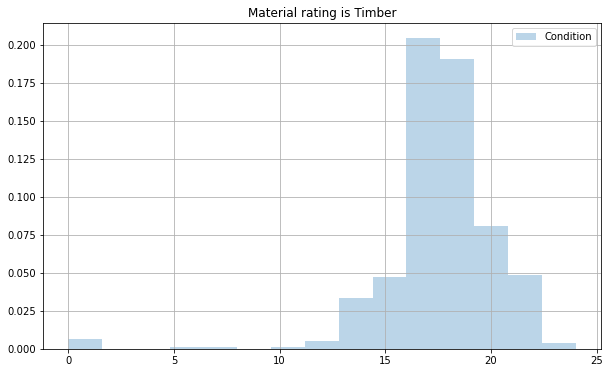

In [ ]:
axs = gbyMat.hist(column=['Condition'], alpha=0.3, bins=15, density=True, figsize=(10,6), legend=True)
names = ['Concrete',  'Other', 'Steel', 'Timber']
_t = [axs[name][0][col].set_title('Material rating is ' + name) for name in names for col in [0]]

In [ ]:
#The following code creates a group by using the 'Design' category
gbydes = bridges.groupby(by = 'Design')
gbydes.size()

Design
Arch       138
Beam     28187
Frame       68
Other     1257
Slab      4284
Truss      100
dtype: int64

### Histogram of Groups
The histogram method can be applied directly to the 'group by' object. The default behaviour is to show a separate histogram for each group. 

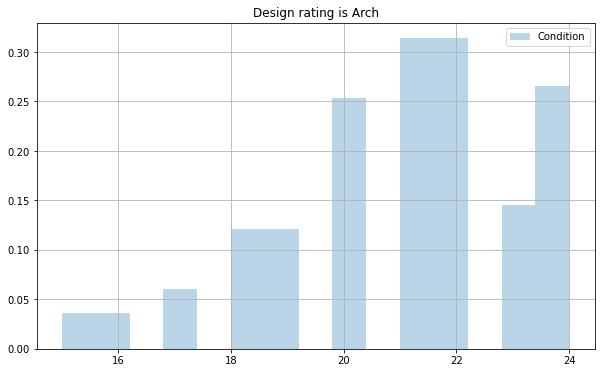

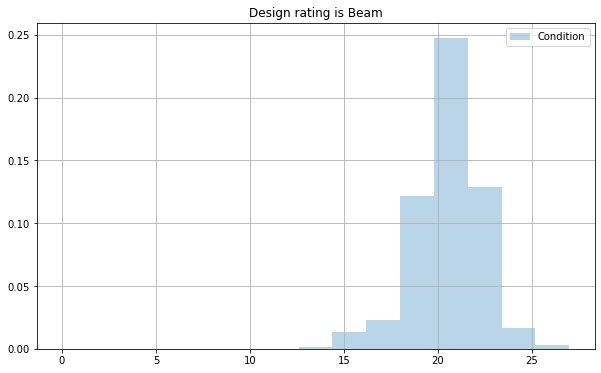

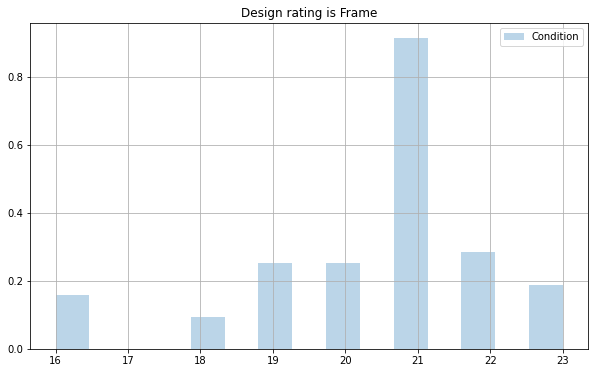

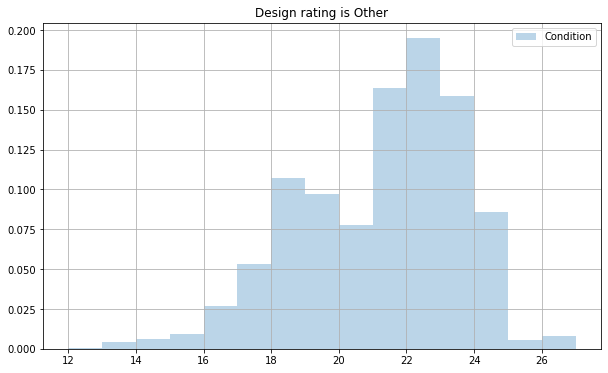

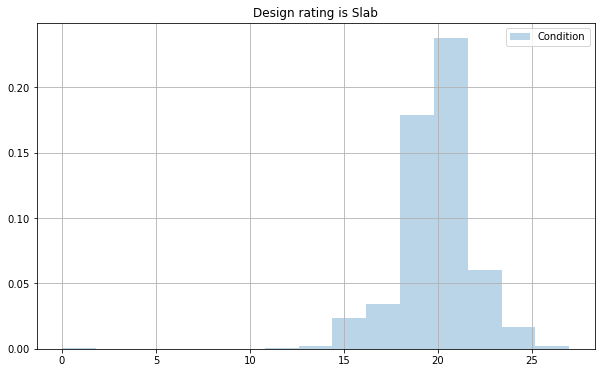

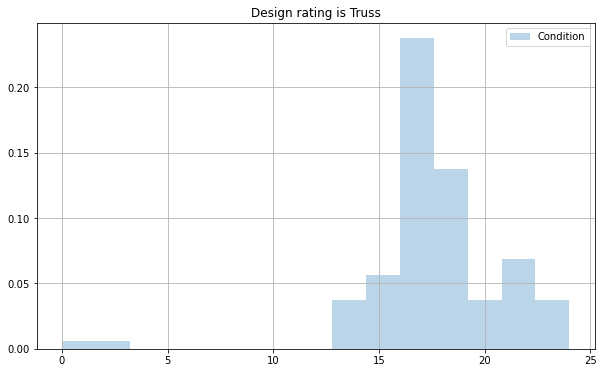

In [ ]:
# below code creating seperate histogram for each group
axs = gbydes.hist(column=['Condition'], alpha=0.3, bins=15, density=True, figsize=(10,6), legend=True)

# This sets the titles
names = ['Arch',  'Beam', 'Frame', 'Other', 'Slab', 'Truss']
_t = [axs[name][0][col].set_title('Design rating is ' + name) for name in names for col in [0]]

## Part 3:  Regression modelling

This section covers and construct a linear regression to look at the effect of the five predictor 
variables on the target variable. In this we, record the R2 (coefficient of determination) and comment on the value. We also see the distribution of residuals (errors) and comment over it. This notebook also explains How to calculate and use of regression coefficients to compare the influence of the different predictors.

### Part 3.1: R2 (coefficient of determination) and comment

In [ ]:
y = bridges.Condition # this is the target variable

# Code below will create a matrix X
X = np.column_stack((bridges.AverageDaily, bridges.Trucks_percent, bridges.Age )) # these are the predictors
X[0:5]

array([[  1.,   0.,  16.],
       [  1.,   0.,  16.],
       [100.,   0.,   9.],
       [ 80.,   0.,  71.],
       [150.,   4.,  17.]])

In [ ]:
# below code helps in calculating R2 and other coefficients.
reg = LinearRegression().fit(X, y)

print('The R2 coefficient of determination is %4.3f' % reg.score(X, y))
print('The intercept is %4.1f' % reg.intercept_)
beta_AverageDaily, beta_Trucks_percent, beta_Age = reg.coef_
print('Estimated regression coefficient for AverageDaily is %4.2f' % beta_AverageDaily) 
      
print('Estimated regression coefficient for Trucks_percent is %4.2f' % beta_Trucks_percent) 
      
print('Estimated regression coefficient for Age is %4.2f' % beta_Age)

The R2 coefficient of determination is 0.356
The intercept is 22.2
Estimated regression coefficient for AverageDaily is -0.00
Estimated regression coefficient for Trucks_percent is 0.02
Estimated regression coefficient for Age is -0.05


### Using Categorical Predictors

To use categorical predictors, we must transform them using reference encoding. Pandas provides a very simple way to do this, using `get_dummies`. For reference encoding we use the first value of the categorical variable as a reference, so this is dropped from the dummy variables. 

In [ ]:
Mat_d = pd.get_dummies(bridges.Material, drop_first=True)
Mat_d

,Other,Steel,Timber
Structure_id,,,
000021521-00101,0,0,0
000021521-00181,0,0,0
000021521-TMP20,0,0,0
000021525-00012,0,0,1
000021580-00092,0,0,0
...,...,...,...
DAPFORHOO000012,0,0,0
DAPFORHOO000013,0,0,0
DAPFORHOO000015,0,0,0


In [ ]:
Des_d = pd.get_dummies(bridges.Design, drop_first=True)
Des_d

,Beam,Frame,Other,Slab,Truss
Structure_id,,,,,
000021521-00101,0,0,0,1,0
000021521-00181,0,0,0,1,0
000021521-TMP20,1,0,0,0,0
000021525-00012,1,0,0,0,0
000021580-00092,1,0,0,0,0
...,...,...,...,...,...
DAPFORHOO000012,1,0,0,0,0
DAPFORHOO000013,1,0,0,0,0
DAPFORHOO000015,1,0,0,0,0


In [ ]:
# below code creating matrix X2 and calculating other categorival variable coefficients.
X2 = np.column_stack((bridges.AverageDaily, bridges.Trucks_percent, bridges.Age, Mat_d.Other, Mat_d.Steel, Mat_d.Timber, Des_d.Beam, Des_d.Frame, Des_d.Other, Des_d.Slab, Des_d.Truss ))
reg2 = LinearRegression().fit(X2, y)

print('The R2 coefficient of determination is %4.3f' % reg2.score(X2, y))
print('The intercept is %4.1f' % reg2.intercept_)
print('The regression coefficients are:', reg2.coef_)

The R2 coefficient of determination is 0.456
The intercept is 23.7
The regression coefficients are: [-1.52819784e-06  5.02934222e-03 -4.89942811e-02  1.80198785e-02
 -1.38768804e+00 -3.20120119e+00 -1.13352194e+00 -8.53724370e-01
 -1.26807449e+00 -1.21468172e+00 -1.28643349e+00]


### Part 3.2 Comparing the Coefficients

It is *really important* to realise that the coefficients of a linear regression have units. The values will change if we scale the predictors. I have written out the units in detail. Because the units are different, we need to take care when we compare them. You cannot sensibly compare the height of someone in metre with the rating they give to music by the Beatles.

In [ ]:
AverageDaily_range = bridges.AverageDaily.quantile(0.9) - bridges.AverageDaily.quantile(0.1)
age_range = bridges.Age.quantile(0.9) - bridges.Age.quantile(0.1)
Trucks_percent_range = bridges.Trucks_percent.quantile(0.9) - bridges.Trucks_percent.quantile(0.1)
Condition_range = bridges.Condition.quantile(0.9) - bridges.Condition.quantile(0.1)

print('AverageDaily_range (10th to 90th centile) is %3.1f' % AverageDaily_range, 'vehicles')
print('Age range (10th to 90th centile) is %3.1f' % age_range, 'years')
print('Trucks_percent_range (10th to 90th centile) is %3.1f' % Trucks_percent_range, 'percent')
print('Condition (10th to 90th centile) is %3.1f' % Condition_range, 'rating')

AverageDaily_range (10th to 90th centile) is 29150.0 vehicles
Age range (10th to 90th centile) is 61.0 years
Trucks_percent_range (10th to 90th centile) is 23.0 percent
Condition (10th to 90th centile) is 5.0 rating


In [ ]:
print ('The change in Condition (as a percent of its range) given by the AverageDaily coefficient (over its range) is %4.1f percent'
       % (100 * (beta_AverageDaily * AverageDaily_range) / Condition_range))

print ('The change in Condition (as a percent of its range) given by the age coefficient (over its range) is %4.1f percent'
       % (100 * (beta_Age * age_range) / Condition_range))

print ('The change in Condition (as a percent of its range) given by the Trucks_percent coefficient (over its range) is %4.1f percent'
       % (100 * (beta_Trucks_percent * Trucks_percent_range) / Condition_range))

The change in Condition (as a percent of its range) given by the AverageDaily coefficient (over its range) is -0.1 percent
The change in Condition (as a percent of its range) given by the age coefficient (over its range) is -63.3 percent
The change in Condition (as a percent of its range) given by the Trucks_percent coefficient (over its range) is  8.0 percent


### Part 3.3 Distribution of errors and comment

We can use the `predict` method to return the predicted values of the target variable. Then we can calculate the errors and show their distribution.

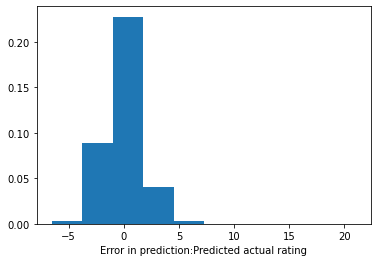

In [ ]:
y_hat = reg.predict(X)

fig, a1 = plt.subplots(1, 1)
residuals = y_hat - y
a1.hist(residuals, bins=10, density=True)
_ = a1.set_xlabel('Error in prediction:Predicted actual rating')

In [ ]:
# The mean squared error
print('Root of the mean squared error: %.2f'% mean_squared_error(y, y_hat, squared=False))

Root of the mean squared error: 1.60


Text(0, 0.5, 'Actual Value')

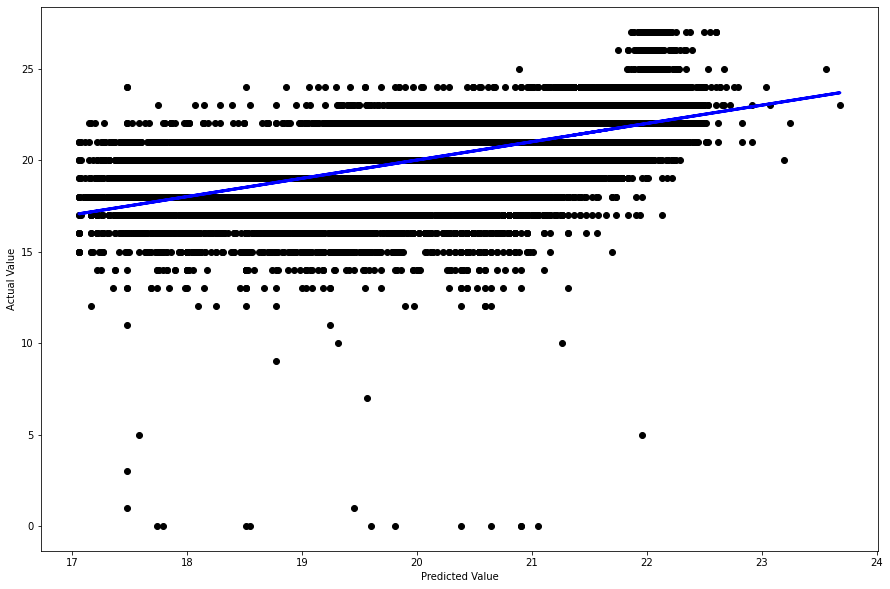

In [ ]:
# Plot outputs
fig, a = plt.subplots(1,1,figsize=(15,10))
a.scatter(y_hat, y,  color='black')
a.plot(y_hat, y_hat, color='blue', linewidth=3)

# two_std = residuals.std() * 2
# a.errorbar(y_hat, y, yerr=two_std, fmt='.k')

a.set_xlabel('Predicted Value')
a.set_ylabel('Actual Value')

### Regression coefficients are

- Age = -0.05
- AverageDaily = -0.00
- Trucks_percent = 0.02

Material type
- Steel = -1.38
- Timber = -3.20
- other material = 1.80

Design type
- Beam = -1.13
- frame = -8.53
- other desisn = -1.27
- Slab = -1.21
- Truss = -1.29

### How well the proposed variables can predict the bridge condition

- Age: As the age of bridges increases, bridge condition will deteriorate as it has negetive correlation with it.
- AverageDaily- We can not predict the bridge condition by AverageDaily variable as it has no correlation with it.
- Truck_percent - As the Trucks_percent increases, bridge condition will deteriorate in long run as it has very less negetive correlation with it.

### Which of the proposed variables has more influence on the current condition.

'Material' and 'Design' variables have more influence on the current condition.